In [53]:
### 量化竞争站点变化价格对我方销量的影响
### CompetingStationsPrice_ChangePrice
# 结论1：竞争站点的与我站的柴油价格差，决定了柴油销量
# 结论2：竞争站点的与我站的汽油价格差，无法决定汽油销量。 但我站与我站之前的汽油价格差，会决定汽油销量。
# 结论3：我方站点的价格与竞争对方的价格是强相关的


In [54]:
### STEP1：读取数据 ###
import pandas as pd

COLS_DATE = 'date'
COLS_PRICE = '60000305_price'                   #92号国六B
COLS_PRICE_OTHER = '60000305_price_other'
COLS_AMOUNT = '60000305_amount'  
COLS_ALL = [COLS_DATE, 
            COLS_PRICE, COLS_PRICE_OTHER, COLS_AMOUNT
            ]


# 读取excel文件并获取指定列
df = pd.read_csv('../Data/竞争站分析-竞争站-单站-32801817.csv', usecols=COLS_ALL, encoding='GBK')
print(df.head())

       date  60000305_price 60000305_price_other  60000305_amount
0  2023-1-1            7.55   [5.49, 7.35, 7.55]         31877.99
1  2023-1-2            7.55   [5.49, 7.35, 7.55]         34901.52
2  2023-1-3            7.55   [5.49, 7.35, 7.55]         29739.29
3  2023-1-4            7.75         [5.49, 7.75]         24860.71
4  2023-1-5            7.75   [5.49, 7.55, 7.75]         24913.79


In [55]:
### STEP2：添加特征列
import CompetingStationPrice_Utils as utils

# 新列：竞争站点价格
df[COLS_PRICE_OTHER] = df[COLS_PRICE_OTHER].apply(utils.get_second_lowest_price)

# 新列：当前油品的价格变化（相较前一日）
df['价格变化'] = df[COLS_PRICE] - df[COLS_PRICE].shift(1)
df['价格变化'] = df['价格变化'].fillna(0)

# 新列：当前油品的竞争价格变化
df['竞争站价格变化'] = df[COLS_PRICE_OTHER] - df[COLS_PRICE_OTHER].shift(1)
df['竞争站价格变化'] = df['竞争站价格变化'].fillna(0)

# 新列：当前油品的差价
df['价格差'] = df[COLS_PRICE] - df[COLS_PRICE_OTHER]        # 我们比对方贵为正数， 便宜为负数

# 新列：当前油品的价差变化
df['价格差变化'] = df['价格差'] - df['价格差'].shift(1)
df['价格差变化'] = df['价格差变化'].fillna(0)
print(df)

           date  60000305_price  60000305_price_other  60000305_amount  价格变化  \
0      2023-1-1            7.55                  7.35         31877.99   0.0   
1      2023-1-2            7.55                  7.35         34901.52   0.0   
2      2023-1-3            7.55                  7.35         29739.29   0.0   
3      2023-1-4            7.75                  7.75         24860.71   0.2   
4      2023-1-5            7.75                  7.55         24913.79   0.0   
..          ...             ...                   ...              ...   ...   
360  2023-12-27            7.51                  7.21         42292.03   0.0   
361  2023-12-28            7.51                  7.21         44862.37   0.0   
362  2023-12-29            7.51                  7.21         45853.18   0.0   
363  2023-12-30            7.51                  7.21         47039.11   0.0   
364  2023-12-31            7.51                  7.21         56599.35   0.0   

     竞争站价格变化  价格差  价格差变化  
0        0.0

60000305_price与60000305_price_other相关系数：
Pearson相关系数: -0.14454018778791272, p值: 0.005666049868639299
Spearman相关系数: 0.13025806525601197, p值: 0.012750574089033238
Kendall相关系数: 0.10277896678022552, p值: 0.006698006344998408


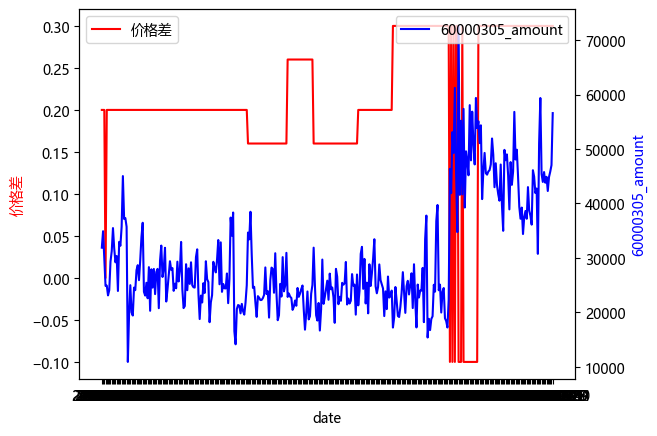

In [56]:
### STEP3：确认相关性

from scipy.stats import pearsonr, spearmanr, kendalltau

# 定义数据列
COLS_X = COLS_DATE
COLS_Y1 = '价格差'   # 检验相关性的两列之一
COLS_Y2 = COLS_AMOUNT    # 检验相关性的两列之二

# 确保这两列没有缺失值
df_clean = df[[COLS_Y1, COLS_Y2]].dropna()

# 使用Pearson相关系数计算相关性及p值
pearson_corr, pearson_pvalue = pearsonr(df_clean[COLS_Y1], df_clean[COLS_Y2])
spearman_corr, spearman_pvalue = spearmanr(df_clean[COLS_Y1], df_clean[COLS_Y2])
kendall_corr, kendall_pvalue = kendalltau(df_clean[COLS_Y1], df_clean[COLS_Y2])

# 打印结果
print(F"{COLS_PRICE}与{COLS_PRICE_OTHER}相关系数：")
print(f"Pearson相关系数: {pearson_corr}, p值: {pearson_pvalue}")
print(f"Spearman相关系数: {spearman_corr}, p值: {spearman_pvalue}")
print(f"Kendall相关系数: {kendall_corr}, p值: {kendall_pvalue}")

# 打印折线图
import matplotlib.pyplot as plt

# 设置字体，确保能正确显示汉字
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体

# 创建一个图表和轴对象
fig, ax1 = plt.subplots()

# 绘制第一条曲线
ax1.plot(df[COLS_X], df[COLS_Y1], 'r-', label=COLS_Y1)
ax1.set_xlabel(COLS_X)
ax1.set_ylabel(COLS_Y1, color='r')

# 利用twinx()创建第二个Y轴
ax2 = ax1.twinx()

# 绘制第二条曲线
ax2.plot(df[COLS_X], df[COLS_Y2], 'b-', label=COLS_Y2)
ax2.set_ylabel(COLS_Y2, color='b')

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图表
plt.show()